### 1. Import các thư viện cần thiết

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 2. Mô tả, phân tích tập dữ liệu

Bộ dữ liệu Movielens thông thường sẽ gồm 3 dataframes chính users, movies và ratings lần lượt chứa thông tin của người dùng, bộ phim và các đánh giá. Vì mục đích minh họa nhanh thuật toán, em sẽ dùng tập dữ liệu movielens 100k để gọn nhẹ hơn.

#### 2.1 Rating

Dưới đây là 10 dòng đầu tiên của rating. Dữ liệu rating bao gồm thông tin về mã người dugnf userID, mã phim MovieID, đánh giá trong thang điểm 5 và thời điểm đánh giá Timestamp

In [131]:
ratings = pd.read_csv('ratings.csv')
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


Vẽ biểu đồ phân phối cho cột rating:

<AxesSubplot:ylabel='Frequency'>

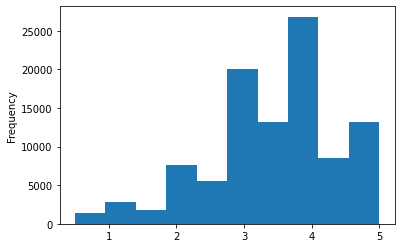

In [69]:
ratings['rating'].plot.hist()

Biểu đồ trên cho ta thấy điểm 4 được đánh giá nhiều nhất trong khi các điểm 1 và 2 có ít lượng đánh giá nhất. Điều này có thể được giải thích bằng sự thật là người dùng thường đánh giá khi họ rất thích một bộ phim, khi họ không thực sự thích, họ sẽ ít ra đánh giá hơn

#### 2.2 Dữ liệu bộ phim

In [70]:
movies = pd.read_csv('movies.csv')
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [53]:
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


Tập dữ liệu 9742 bộ phim với các thông tin về id, tiêu đề (title) và thuộc các thể loại (genres)

### 3. Cơ sở lý thuyết

Để xây dựng được Hệ thống đề xuất firm với Matrix factorization và Proximal Gradient Descent, ta cần nắm:
- Hệ thống đề xuất Matrix Factorization 
- Proximal Gradient Descent

#### 3.1 Hệ thống đề xuất Matrix Factorization

Hệ thống đề xuất có thể hiểu đơn giản là bài toán điền vào ma trận Utility sau:
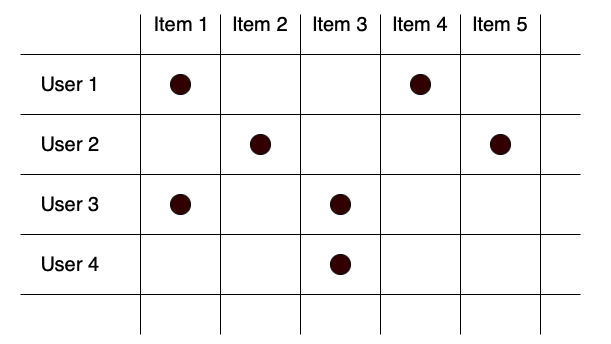

Trong đó:
- Mỗi hàng thể hiện một người dùng
- Mỗi cột thể hiện một sản phẩm
- Mỗi chấm đen thể hiện mức độ quan tâm của người dùng tới sản phẩm tương ứng

Có nhiều cách tiếp cận cho bài toán trên, nhưng một cách đơn giản nhưng lại hiệu quả hơn khá nhiều so với cách truyền thống (Content-based) là **Matrix Factorization**. Phương pháp này xấp xỉ các giá trị đã biết trong ma trận utility thành tích của hai ma trận có chiều thấp hơn.

Với một người dùng j và sản phẩm j với vector đặc trưng lần lượt là $w_i$ và $x_j$, sự quan tâm của người dùng tới sản phẩm đó có thể được biểu diễn:
$$\hat{y}_{ij} \approx \mathbf{w}_i^T \mathbf{x}_j + b_i + d_j + a ~~~~~(1)$$

Trong đó:
- $b_i$ là bias ứng với người dùng ($w_i$)
- $d_j$ là bias ứng với sản phẩm ($x_j$)
- $a$ là hệ số tự do thể hiện thiên hướng chung của bộ dữ liệu (thường là kỳ vọng)

Hàm mất mát tương tự với hồi quy tuyến tính (có thể áp dụng regularization):
$$\mathcal{L}(\mathbf{X}, \mathbf{W}) = \frac{1}{2s} \sum_{i=1}^m \sum_{j:r_{ij} = 1}^n (\mathbf{w}^T_i\mathbf{x}_j + b_i + d_j - y_{ij})^2 + \frac{\lambda}{2} (||\mathbf{X}||_F^2 + ||\mathbf{W}||_F^2) ~~~~~ (2)$$

Trong đó:
- $j: r_{ij}$ được hiểu là các giá trị của j sao cho $r_{ij} = 1$ hay người dùng thứ j đã đánh giá sản phẩm thứ j
- $\lambda$ là hyperparameter cho $l_2$ regularization (dùng để tránh overfitting)

Tối ưu hàm mất mát trên bằng cách cập nhật X và W thay phiên nhau. Khi cập nhật X thì giữ nguyên W và ngược lại. Đạo hàm tương tự Linear Regression nên không trình bày lại.

#### 3.2 Proximal Gradient Descent

**Proximal Gradient Descent** là một thuật toán tối ưu hóa được sử dụng để giải quyết bài toán tối ưu hóa có điều kiện. Nó kết hợp giữa phương pháp Gradient Descent và phương pháp Proximal Operator để xử lý các điều kiện ràng buộc.

Proximal Operator của một hàm g được định nghĩa như sau:
$$prox_{\alpha g} = argmin_z(g(z) + \frac{1}{2\alpha}||z - x||_2^2)$$

Cho một hàm mục tiêu $f(x)$ được phân rã thành hai thành phần g(x) và h(x), tức là $f(x) = g(x) + h(x)$. Công thức cập nhật của Proximal Gradient Descent như sau:
$$ x^{(k+1)}=prox_{\alpha h}(x^{(k)} - \alpha \nabla g(x^{(k)})) $$
Việc dùng Proximal Operator để đảm bảo $x^{(k+1)}$ thỏa mãn ràng buộc của h(x)

Bài toán Matrix Factorization với tập dữ liệu Movielens chỉ có ràng buộc duy nhất là Non-negativity Constraints

### 4 Xây dựng mô hình

In [174]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

class MatrixFactorization():
    def __init__(self, num_users, num_items, K, lam=0.02, Xinit=None, Winit=None,
                 learning_rate=0.005, max_epoch=20, print_every=2):
        self.n_users = num_users
        self.n_items = num_items
        self.X = 0.1 * np.random.randn(num_items, K) if Xinit is None else Xinit
        self.W = 0.1 * np.random.randn(num_users, K) if Winit is None else Winit
        self.b = np.zeros(num_items)  # item biases
        self.d = np.zeros(num_users)  # user biases
        self.K = K  # Number of latent factors
        self.lam = lam  # regularization parameter
        self.mu = 0 # mean of rating
        self.learning_rate = learning_rate
        self.max_epoch = max_epoch  # maximum number of iterations
        self.print_every = print_every  # print loss + RMSE on training data after each ? iters

    def fit(self, data):
        users = data[:, 0]
        items = data[:, 1]
        ratings = data[:, 2]
        n_ratings = data.shape[0]
        self.mu = np.mean(ratings)
        
        for it in range(self.max_epoch):
            # mix data
            idx = np.random.permutation(n_ratings)
            for n in idx:
                u, i, rating = int(users[n]), int(items[n]), ratings[n]
                pred_rating = self.X[i].dot(self.W[u]) + self.b[i] + self.d[u] + self.mu
                error = pred_rating - rating

                # Update biases
                self.b[i] -= self.learning_rate * (error + self.lam * self.b[i])
                self.d[u] -= self.learning_rate * (error + self.lam * self.d[u])

                # Update factors using Proximal Gradient Descent
                self.X[i, :] = self.proximal_update(self.X[i, :], self.W[u, :], error, self.learning_rate, self.lam)
                self.W[u, :] = self.proximal_update(self.W[u, :], self.X[i, :], error, self.learning_rate, self.lam)

            if (it + 1) % self.print_every == 0 or (it + 1) == 1:
                rmse_train = self.evaluate_RMSE(data)
                print('iter = %d, loss = %.4f, RMSE train = %.4f' % (it + 1, self._loss(data), rmse_train))

    def proximal_operator(self, x, lam, learning_rate):
        return np.maximum(x, 0)

    def proximal_update(self, x, z, error, learning_rate, lam):
        """
        Proximal update for the factors.
        """
        gradient = error * z + lam * x
        proximal_term = learning_rate * gradient
        x = self.proximal_operator(x - proximal_term, lam, learning_rate)
        return x
    

    def pred(self, u, i):
        """
        predict the rating of user u for item i
        """
        u, i = int(u), int(i)
        pred = self.X[i, :].dot(self.W[u, :]) + self.b[i] + self.d[u] + self.mu
        return max(0, min(5, pred))  # pred should be between 0 and 5 in MoviesLen

    def evaluate_RMSE(self, rate_test):
        n_tests = rate_test.shape[0]  # number of test
        SE = 0  # squared error
        for n in range(n_tests):
            pred = self.pred(rate_test[n, 0], rate_test[n, 1])
            SE += (pred - rate_test[n, 2]) ** 2

        RMSE = np.sqrt(SE / n_tests)
        return RMSE

    def _loss(self, data):
        L = 0
        for n in range(data.shape[0]):
            u, i, rating = int(data[n, 0]), int(data[n, 1]), data[n, 2]
            pred_rating = self.X[i, :].dot(self.W[u, :]) + self.b[i] + self.d[u] + self.mu
            L += 0.5 * (pred_rating - rating) ** 2 + 0.5 * self.lam * (
                    self.b[i] ** 2 + self.d[u] ** 2 + np.sum(self.X[i, :] ** 2) + np.sum(self.W[u, :] ** 2))

        return L / data.shape[0]


### 5. Triển khai mô hình

#### 5.1 Phân chia tập train và test

In [175]:
ratings_data = ratings.iloc[:, :-1].values
print(ratings_data.shape)

(100836, 3)


In [176]:
ratings_train = ratings_data[:80000]
ratings_test = ratings_data[80000:]
print(ratings_train.shape)
print(ratings_test.shape)

(80000, 3)
(20836, 3)


#### 5.2 Huấn luyện mô hình

In [177]:
num_users = int(np.max(ratings_data[:, 0])) + 1
num_items = int(np.max(ratings_data[:, 1])) + 1
recommendation_sys = MatrixFactorization(num_users, num_items, K = 100, lam = .1, print_every = 1, 
                        learning_rate = 0.05, max_epoch = 10)
recommendation_sys.fit(ratings_train)

iter = 1, loss = 0.4075, RMSE train = 0.8595
iter = 2, loss = 0.3849, RMSE train = 0.8363
iter = 3, loss = 0.3730, RMSE train = 0.8229
iter = 4, loss = 0.3643, RMSE train = 0.8127
iter = 5, loss = 0.3583, RMSE train = 0.8039
iter = 6, loss = 0.3539, RMSE train = 0.7980
iter = 7, loss = 0.3522, RMSE train = 0.7936
iter = 8, loss = 0.3494, RMSE train = 0.7896
iter = 9, loss = 0.3453, RMSE train = 0.7828
iter = 10, loss = 0.3425, RMSE train = 0.7767


#### 5.3 Đánh giá mô hình

In [173]:
RMSE = recommendation_sys.evaluate_RMSE(ratings_test)
print(f'\nMatrix Factorization CF, RMSE = {RMSE}')


Matrix Factorization CF, RMSE = 0.9891968338856711


### 6. Kết luận

So sánh với các kết quả với các recommendation systems khác thì chỉ với 10 epochs thì kết quả trên là tương đối ổn. Tuy nhiên, vì hàm mất mát tương đối đơn giản (hàm tuyến tính) và lượng dữ liệu không nhiều nên rõ ràng mô hình sẽ không quá tốt được.